In [ ]:
#libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


In [ ]:
#import data
df = pd.read_csv("470-data.csv")
print(df.head())
print(df.columns)
print("Unique months:", df['M'].unique())

# Check for invalid days
print("Unique days:", df['D'].unique())

# Check for invalid hours
print("Unique hours:", df['HH'].unique())

# Check for invalid minutes
print("Unique minutes:", df['MM'].unique())
print(df.columns.tolist())


   RequestID      Boro    Yr  M  D  HH  MM  Vol  SegmentID  \
0      23584  Brooklyn  2016  7  3  15   0  186     150372   
1      23584  Brooklyn  2016  7  3  15  15  207     150372   
2      23584  Brooklyn  2016  7  3  15  30  186     150372   
3      23584  Brooklyn  2016  7  3  15  45  170     150372   
4      23584  Brooklyn  2016  7  3  16   0  161     150372   

                                       WktGeom          street  \
0  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
1  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
2  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
3  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   
4  POINT (997355.9816928023 208572.9762857783)  PULASKI BRIDGE   

                    fromSt      toSt Direction  
0  Newtown Creek Shoreline  Dead end        NB  
1  Newtown Creek Shoreline  Dead end        NB  
2  Newtown Creek Shoreline  Dead end        NB  
3  Newtown Creek Shoreline  Dead e

In [ ]:
#preprocess
cols = ['Yr', 'M', 'D', 'HH', 'MM']

df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

df = df.dropna(subset=cols)

# Build the timestamp safely
def build_timestamp(row):
    try:
        return datetime(
            year=int(row['Yr']),
            month=int(row['M']),
            day=int(row['D']),
            hour=int(row['HH']),
            minute=int(row['MM'])
        )
    except Exception as e:
        print(f"Bad row at index {row.name}: {e}")
        return pd.NaT

df['timestamp'] = df.apply(build_timestamp, axis=1)
df = df.dropna(subset=['timestamp'])

In [ ]:
#Timestamp Altering
df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
df = df[df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]


print(df.head())
grouped = df.groupby(['weekday', 'hour'])['Vol'].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
grouped['weekday'] = pd.Categorical(grouped['weekday'], categories=weekday_order, ordered=True)
grouped = grouped.sort_values(['weekday', 'hour'])


NameError: name 'df' is not defined

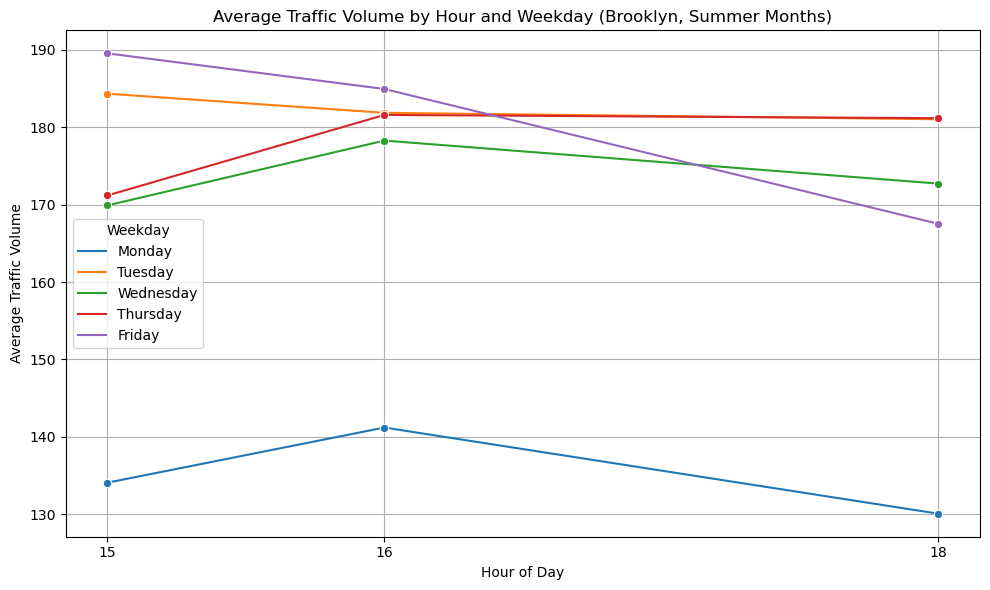

In [ ]:
#Visualize
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='hour', y='Vol', hue='weekday', marker='o')
plt.title('Average Traffic Volume by Hour and Weekday (Brooklyn, Summer Months)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks([15, 16, 18])  # Because you filtered for 3pm, 4pm, 6pm
plt.grid(True)
plt.legend(title='Weekday')
plt.tight_layout()
plt.show()

In [ ]:
df_hour = df[df['HH'] == 16].copy()

# Build timestamp if not already present
if 'timestamp' not in df_hour.columns:
    df_hour['timestamp'] = pd.to_datetime(df_hour[['Yr', 'M', 'D', 'HH', 'MM']])

# Group by date to get average volume at 4 PM
daily_traffic = df_hour.groupby(df_hour['timestamp'].dt.date)['Vol'].mean().reset_index()
daily_traffic.columns = ['date', 'avg_volume']
daily_traffic['date'] = pd.to_datetime(daily_traffic['date'])
daily_traffic['year'] = daily_traffic['date'].dt.year

# Create train/test splits
train_df = daily_traffic[daily_traffic['year'].isin([2016, 2018, 2021])].copy()
test_df = daily_traffic[daily_traffic['year'] == 2022].copy()

# Add features
train_df['dayofweek'] = train_df['date'].dt.day_name()
train_df['trend'] = range(len(train_df))

test_df['dayofweek'] = test_df['date'].dt.day_name()
test_df['trend'] = range(len(train_df), len(train_df) + len(test_df))

# One-hot encode 'dayofweek'
train_encoded = pd.get_dummies(train_df, columns=['dayofweek'], drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=['dayofweek'], drop_first=True)

# Fix any missing columns in test set
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

In [ ]:
X_train = train_encoded.drop(columns=['date', 'avg_volume', 'year'])
y_train = train_encoded['avg_volume']

X_test = test_encoded[X_train.columns]
y_test = test_df['avg_volume']

# Fit model and predict
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_model.fit(X_train, y_train)
y_pred_elastic = elastic_model.predict(X_test)

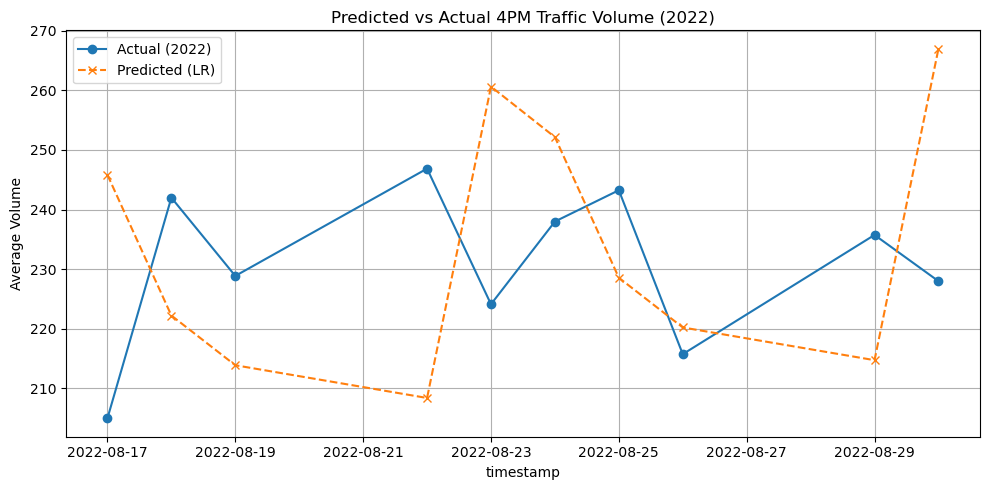

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_df['date'], y_test, label='Actual (2022)', marker='o')
plt.plot(test_df['date'], y_pred, label='Predicted (LR)', linestyle='--', marker='x')
plt.title("Predicted vs Actual 4PM Traffic Volume (2022)")
plt.xlabel("timestamp")
plt.ylabel("Average Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 24.38586895039258
MSE: 749.1175709945908
R² Score: -3.7915302430522235
